# Deep Q-Network (DQN)

드디어 DQN이다! DQN은 Q-Network을 improve한 버전으로 다음 세가지 큰 차이가 있다.

1. layer가 하나인 NN -> 여러층의 CNN
2. Experience Replay
  * agent의 경험을 저장해두고 이를 랜덤하게 뽑아서 batch를 만들어 학습에 이용
  * `<state, action, reward, next state>`로 이루어짐
  * 고정된 크기의 버퍼가 존재하며, 새로 들어온 녀석이 오래전 녀석을 밀어낸다.
3. target Q-value($max Q(s, a)$)를 계산하는 target NN을 따로 사용
  * 이렇게하면 더 안정적으로 학습이 가능하다고한다. [딥마인드 논문](https://arxiv.org/pdf/1509.02971.pdf)

## And More...
여기에 DQN의 성능을 올리기 위해 사용된 기법 두가지를 더해보자.

### Double DQN
* 관찰: 자주 보이는 state에 대한 action의 Q-value를 과대평가한다.
* 수정: target Q-value를 구할 때, max값을 취하는 것이 아니라 주요 신경망이 action을 선택하고, 그 행동에 대한 target Q-value를 가져온다.
$\hat{Q}(s,a) = r(s,a) + \gamma \cdot Q(s', argmax_{a_i}Q(s', a_i, \theta 1), \theta 2)$
> $\theta 1$은 주요 network의 파라미터, $\theta 2$는 target Q-value를 계산하는 network의 파라미터이다.


### Dueling DQN

* Q(s, a): 어떤 상태에서 어떤 행동을 취했을 때의 reward
* V(s): 상태에 대한 reward
* A(a): 행동에 대한 reward
* Q(s, a) = V(s) + A(a)

위처럼 Q(s, a)를 두가지로 분리해서 V(s), A(a)를 계산하고 이를 합쳐서 Q(s, a)를 구하는 방식이다.

# Coding~~

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

## 게임환경
agent는 파란색 사각형이며 빨간색 사각형을 피하고(R:-1) 초록색 사각형(R: 1)으로 이동하는 것이다.

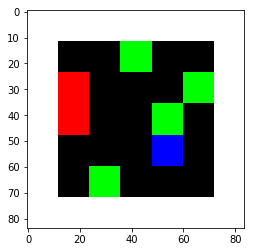

In [36]:
from gridworld import gameEnv

env = gameEnv(partial=False, size=5)

## Network

In [55]:
# 신경망 구현
class Qnetwork():
    def __init__(self):
        # 21168 = 84*84*3
        self.scalarInput = tf.placeholder(shape=[None, 21168],
                                          dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,
                                  shape=[-1, 84, 84, 3])
        
        # (image_size - filter_size) / stride + 1 
        # output: [B x 20 x 20 x 32]
        self.conv1 = tf.contrib.layers.conv2d(
            inputs=self.imageIn,
            num_outputs=32,
            kernel_size=[8,8],
            stride=[4,4],
            padding='VALID',
            biases_initializer=None)
        # output: [B x 9 x 9 x 64]
        self.conv2 = tf.contrib.layers.conv2d(
            inputs=self.conv1,
            num_outputs=64,
            kernel_size=[4,4],
            stride=[2,2],
            padding='VALID',
            biases_initializer=None)

        # output: [B x 7 x 7 x 64]
        self.conv3 = tf.contrib.layers.convolution2d(
            inputs=self.conv2,
            num_outputs=64,
            kernel_size=[3,3],
            stride=[1,1],
            padding='VALID',
            biases_initializer=None)

        # output: [B x 1 x 1 x 512]
        self.conv4 = tf.contrib.layers.convolution2d(
            inputs=self.conv3,
            num_outputs=512,
            kernel_size=[7,7],
            stride=[1,1],
            padding='VALID',
            biases_initializer=None)
        
        ############### Dueling DQN 적용 ################
        # 마지막 콘볼루션 레이어의 출력을 2로 나눈다.
        # streamAC, streamVC 는 각각 [B x 1 x 1 x 256]
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3)
        
        # A flattened tensor with shape [batch_size, k].
        self.streamA = tf.contrib.layers.flatten(self.streamAC)
        self.streamV = tf.contrib.layers.flatten(self.streamVC)
        
        # 256개의 노드를 곱해서 각각 A와 V를 구하는 가중치
        self.AW = tf.Variable(tf.random_normal([256, env.actions]))
        self.VW = tf.Variable(tf.random_normal([256, 1]))
        # 점수화 한다.
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VW)
        # activation function은 없네...
        
        # normalize except std.
        self.Qout = self.Value + tf.subtract(self.Advantage,
                                             tf.reduce_mean(self.Advantage,
                                                            reduction_indices=1,
                                                            keep_dims=True))
        ###############################################
        # get action
        self.predict = tf.argmax(self.Qout, 1)
        
        # 타겟과 예측 Q value 사이의 차이의 제곱합이 손실이다.
        # 타겟Q를 받는 부분
        self.targetQ = tf.placeholder(shape=[None],
                                      dtype=tf.float32)
        # 행동을 받는 부분
        self.actions = tf.placeholder(shape=[None],
                                      dtype=tf.int32)

        self.actions_onehot = tf.one_hot(self.actions,
                                        env.actions,
                                        on_value=1.0,
                                        off_value=0.0)

        # 각 네트워크의 행동의 Q 값을 골라내는 것
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), reduction_indices=1)
        
        # 각각의 차이
        self.td_error = tf.square(self.targetQ - self.Q)
        # 손실
        self.loss = tf.reduce_mean(self.td_error)
        # 최적화 방법 adam
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        # 업데이트 함수
        self.updateModel = self.trainer.minimize(self.loss)

## Experience Replay

In [56]:
class experience_buffer():
    def __init__(self, buffer_size=50000):
        self.buffer = []
        self.buffer_size = buffer_size

    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer))
                         - self.buffer_size] = []
        self.buffer.extend(experience)

    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)), [size, 5])

In [57]:
def flattenState(states):
    '''
    단순히 화면을 flatten시켜주는 함수
    '''
    return np.reshape(states,[21168])

In [58]:
def updateTargetGraph(tfVars, tau):
    # tfVars: 학습 가능한 변수들
    # tau: 타겟 신경망이 학습 신경망을 향하는 비율

    # 학습 가능한 변수들의 수
    total_vars = len(tfVars)
    
    # 연산자 저장 리스트
    op_holder = []
    # 학습 가능한 변수의 절반은 주요 신경망, 절반은 타겟 신경망
    for idx, var in enumerate(tfVars[0:int(total_vars/2)]):
        # 앞의 절반의 값에 tau 값을 곱하면, 주요 신경망의 weight에 곱해지고
        # 뒤의 절반의 값에 1-tau 값을 곱하면, 타겟 신경망의 weight에 곱해져서
        idx_plus_half = int(idx)+int(total_vars/2)
        # 이부분 타겟 신경망을 업데이트하는 부분
        op_holder.append(tfVars[idx_plus_half].assign(tau * var.value()
                                                      + (1 - tau) * tfVars[idx_plus_half].value()))
    return op_holder

def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)

## Training

In [59]:
batch_size = 32
update_freq = 4 # 학습 단계를 얼마나 자주 수행할 것인가
y = .99 
startE = 1
endE = 0.1
anneling_steps = 10000. # startE부터 endE까지 몇단계에 걸쳐서 줄일 것인가.
num_episodes = 10000
pre_train_steps = 10000 # 학습 시작 전에 몇번의 무작위 행위를 할 것인가.
max_epLength = 50
load_model = False
path = "./dqn"
h_size = 512
tau = 0.001 # 주요 신경망을 향해 타겟 신경망이 업데이트되는 비율

In [60]:
tf.reset_default_graph()

mainQN = Qnetwork()
targetQN = Qnetwork()

init = tf.global_variables_initializer()
saver = tf.train.Saver()

trainables = tf.trainable_variables()

# 타겟 신경망을 업데이트하기 위한 값을 만든다
targetOps = updateTargetGraph(trainables, tau)

# 버퍼: episodeBuffer랑은 다른거다.
myBuffer = experience_buffer()

e = startE  # epsilon-greedy
stepDrop = (startE - endE)/anneling_steps


jList = []
rList = []
total_steps = 0

if not os.path.exists(path):
    os.makedirs(path)

indices_dict = {'state': 0,
                'action': 1,
                'reward': 2,
                'next_state': 3,
                'done':4}
with tf.Session() as sess:

    if load_model == True:
        print ('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    sess.run(init)
    # 주요 신경망과 동일하게 타겟 신경망을 설정한다
    updateTarget(targetOps, sess) 
    
    for i in range(num_episodes):
        # initialize episodes
        s = env.reset()
        s = flattenState(s)
        d = False
        rAll = 0
        j = 0
        episodeBuffer = experience_buffer()
        
        # Q-Network
        while j < max_epLength:
            j += 1
            # epsilon-greedy
            if np.random.rand(1) < e or \
               total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                # 신경망을 통해 Q 값을 가져오는 부분
                a = sess.run(mainQN.predict,
                             feed_dict={mainQN.scalarInput:[s]})[0]
            
            # run
            s1, r, d = env.step(a)
            s1 = flattenState(s1)
            total_steps += 1
            
            # 버퍼에 현재 상태, 행동, 보상, 다음 상태, 종료 여부를 저장한다
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),
                                         [1,5])) 
            
            # 무작위 행동의 수를 넘으면 시작
            if total_steps > pre_train_steps:
                # 무작위 확률 값을 줄인다
                if e > endE:
                    e -= stepDrop
                
                # 총 걸음이 업데이트 수로 나누어 떨어지면 시작
                if total_steps % (update_freq) == 0:
                    # 경험으로부터 랜덤한 배치를 뽑는다
                    trainBatch = myBuffer.sample(batch_size) 

                    ####### Double DQN ########
                    # 주요 신경망에서 next_state에 대한 행동을 고른다.
                    pred = sess.run(mainQN.predict,
                                  feed_dict={mainQN.scalarInput: 
                                                 np.vstack(trainBatch[:, indices_dict['next_state']])})
                    # 타겟 신경망에서 Q 값들을 얻는다.
                    Q2 = sess.run(targetQN.Qout,
                                  feed_dict={targetQN.scalarInput: 
                                                 np.vstack(trainBatch[:, indices_dict['next_state']])})

                    end_multiplier = -(trainBatch[:,indices_dict['done']] - 1)  # 종료하면 굳이 해줄 필요가 없지..

                    doubleQ = Q2[range(batch_size), pred]  # Q(s', argmax Q(s', a, theta1) , theta2)
                    ############################
                    targetQ = trainBatch[:, indices_dict['reward']] + (y * doubleQ * end_multiplier)
                    # 우리의 타겟 값들과 함께 신경망을 업데이트해준다.
                    # 행동들에 대해서 targetQ 값과의 차이를 통해 손실을 구하고 업데이트
                    _ = sess.run(mainQN.updateModel,
                                 feed_dict={mainQN.scalarInput: np.vstack(trainBatch[:, indices_dict['state']]),
                                            mainQN.targetQ:     targetQ,
                                            mainQN.actions:     trainBatch[:, indices_dict['action']]})
                    
                    # 주요 신경망과 동일하게 타겟 신경망을 설정한다.
                    # 물론 주요 신경망의 값은 tau 만큼만이 반영된다.
                    updateTarget(targetOps, sess)
            rAll += r
            s = s1
            if d == True:
                break
        
        # 이 에피소드로부터의 모든 경험을 저장한다
        myBuffer.add(episodeBuffer.buffer)

        jList.append(j)
        rList.append(rAll)

        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print ("Saved Model")
        # 최근 10 에피소드의 평균 보상
        if len(rList) % 10 == 0:
            print (total_steps, np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
print ("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Saved Model
500 2.3 1
1000 1.1 1
1500 1.4 1
2000 1.1 1
2500 0.9 1
3000 1.7 1
3500 2.2 1
4000 1.3 1
4500 1.5 1
5000 1.3 1
5500 3.5 1
6000 1.7 1
6500 1.8 1
7000 2.0 1
7500 2.6 1
8000 0.4 1
8500 1.9 1
9000 1.7 1
9500 2.9 1
10000 3.6 1
10500 3.1 0.9549999999999828
11000 1.6 0.9099999999999655
11500 1.2 0.8649999999999483
12000 1.3 0.819999999999931
12500 2.2 0.7749999999999138
13000 1.8 0.7299999999998965
13500 1.2 0.6849999999998793
14000 3.1 0.639999999999862
14500 2.1 0.5949999999998448
15000 2.1 0.5499999999998275
15500 1.2 0.5049999999998103
16000 1.6 0.4599999999998177
16500 0.4 0.41499999999982823
17000 1.4 0.36999999999983874
17500 1.7 0.32499999999984924
18000 0.2 0.27999999999985975
18500 1.0 0.23499999999986562
19000 0.0 0.18999999999986225
19500 1.1 0.14499999999985888
20000 0.7 0.09999999999985551
20500 0.5 0.09999999999985551
21000 0.7 0.09999999999985551
21500 0.1 0.09999999999985551
22000 0.2 0.09999999999985551
22500 1.3 0.09999999999985551
23000 0.9 0.09999999999985551
23

KeyboardInterrupt: 